# DELPHI: Example Demonstration

## Load dependency packages
Note that all of the necessary dependency packages should have been automatically installed if you are running this notebook from within the provided Docker container. If not, you can install the dependencies using the provided `requirements.txt` file using pip: 
```
pip install --upgrade pip && pip install -U -r requirements.txt
```
This notebook assumes familiarity with [Pandas](https://pandas.pydata.org/docs/) and [Seaborn](https://seaborn.pydata.org). In addition, knowledge of [scikit-learn](https://scikit-learn.org/stable/user_guide.html) may be helpful. 

In [349]:
import pickle

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style='ticks')

sns.set_palette("tab10")

sns.set_context('paper')

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix

## Load demonstration models and data
Binary files with models and data are available for download (links in `README.md`). These files should be downloaded and added to the Docker container where they can be accessed below. Alternatively, you can provide your own data here. 

In [350]:
fname = '/tmp/data/demo_models.pickle'    

with open(fname, 'rb') as f:
    
    mdls = pickle.load(f)
    
fname = '/tmp/data/demo_data.pickle'         

with open(fname, 'rb') as f:
    
    d = pickle.load(f)    

## Run demonstration predictions on example data 

Example models and data, along with true values, are provided for this analysis. The example uses data from two-years post-publication, and explores the early-warning signal calculation for the following three years using a subset of the data and features. 

In [351]:
df = pd.DataFrame()
mdf = pd.DataFrame()

for ((y1, y2), m), (X, y) in zip(mdls.items(), d.values()):
    
    # Calculate predictions for example data points and save
    p = m.predict_proba(X)
    
    t = m.predict(X)
    
    idf = pd.DataFrame(p, columns=['lo','hi'])
    
    idf['y1'] = y1
    
    idf['y2'] = y2

    idf['p'] = y
    
    idf['t'] = t
    
    df = pd.concat([df, idf], ignore_index=True)
    
    # Calculate evaluation metrics for example models and save
    mdf = mdf.append([{
        'ba': balanced_accuracy_score(y, t),
        'roc': roc_auc_score(y, p[:,1]),
        'y1': y1,
        'y2': y2
    }], ignore_index=True)
    
df

,lo,hi,y1,y2,p,t
0,1.000000,0.000000,2,3,False,False
1,0.088477,0.911523,2,3,True,True
2,0.558275,0.441725,2,3,False,False
3,1.000000,0.000000,2,3,False,False
4,1.000000,0.000000,2,3,False,False
...,...,...,...,...,...,...
295,0.470591,0.529409,2,5,True,True
296,1.000000,0.000000,2,5,False,False
297,0.816461,0.183539,2,5,False,False
298,0.934911,0.065089,2,5,False,False


In [352]:
mdf

,ba,roc,y1,y2
0,1.000000,1.000000,2,3
1,0.954082,1.000000,2,4
2,0.943299,0.924399,2,5


## Explore results
Now that we have predictions on our example dataset, we can explore the performance of the provided example DELPHI models on our sample dataset. Note that because our example here is a small dataset, the variance is higher that it would be with a larger dataset. 

### Evaluation metrics

We can also explore the trends in predictive performance over time (i.e. as the years post-publication increases). As the dataset size increases, these values converge to the values demonstrated in the manuscript. 

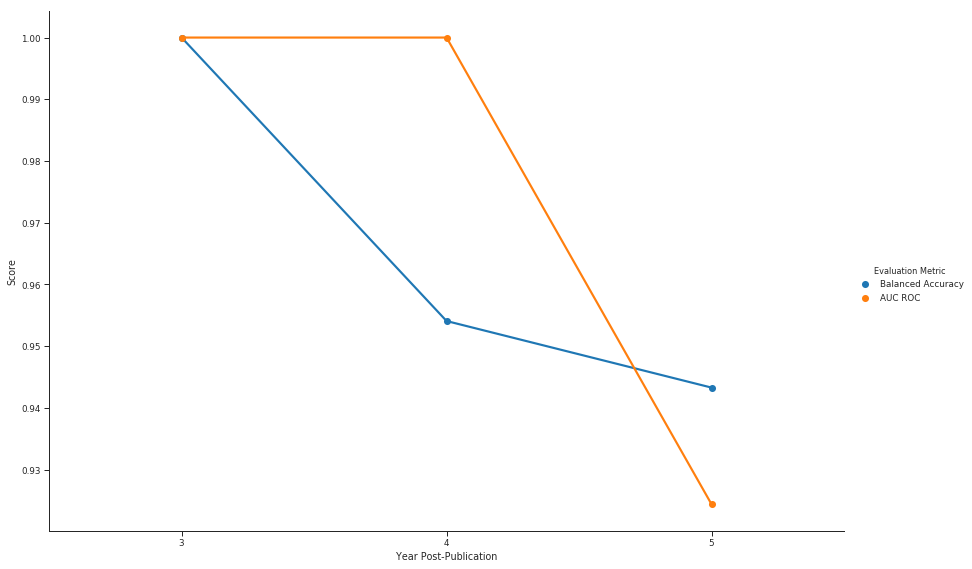

In [371]:
mmdf = mdf.drop('y1', axis=1)

mmdf = mmdf.rename(columns={'ba':'Balanced Accuracy', 'roc':'AUC ROC', 'y2':'Year Post-Publication'})

mmdf = mmdf.melt(id_vars='Year Post-Publication', var_name='Evaluation Metric', value_name='Score')


g = sns.catplot(data=mmdf, x='Year Post-Publication', y='Score', hue='Evaluation Metric', height=8, 
                kind='point', aspect=1.5, legend=True)

### Confusion matrices

We can easily plot and visualize confusion matrices for the performance of our example models on our example data. For clarity, a confusion matrix $C$ has entries $C_{i,j}$ equal to the observations from group $i$ predicted to be in group $j$. In our case, both $i$ and $j$ can be either high-impact or low-impact. 

In [353]:
cdf = pd.DataFrame()

for i in df.y2.unique():
    
    idf = df[df.y2==i]
    
    cm = confusion_matrix(idf.p, idf.t)
    
    cdf = cdf.append(pd.Series(cm.ravel()), ignore_index=True)

cdf.columns = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

cdf['Year Post-Publication'] = df.y2.unique()

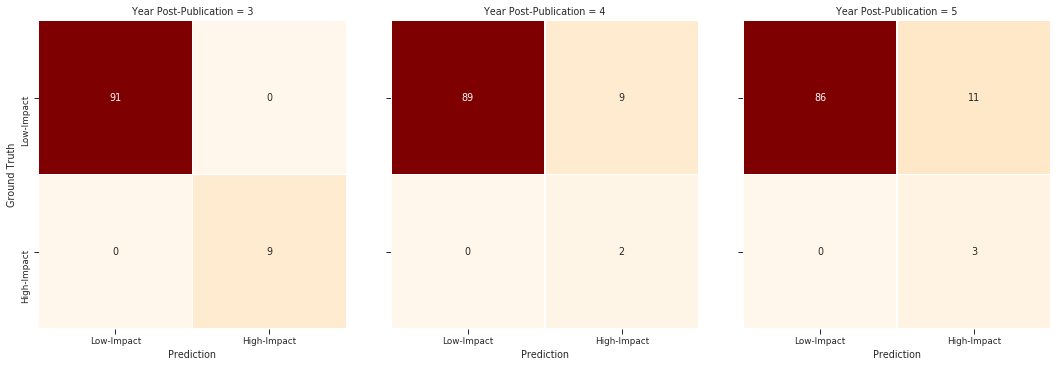

In [354]:
def draw_heatmap(*args, **kwargs):
    
    data = kwargs.pop('data')
    
    d = data.iloc[:,:4].values.reshape(2,2)
    
    sns.heatmap(d, **kwargs)
    
fg = sns.FacetGrid(data=cdf, col='Year Post-Publication', height=5)

ls = ['Low-Impact', 'High-Impact']

fg.map_dataframe(draw_heatmap, cbar=False, annot=True, cmap='OrRd', linewidth=1/2, 
                 square=True, xticklabels=ls, yticklabels=ls)

_ = fg.set_axis_labels("Prediction", "Ground Truth")